In [1]:

import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), 'python/')))
import os

from gestures import config as cfg
from gestures.data_loader.tiny_data_loader import get_tiny_data_loader
from gestures.network.experiment_tracker import get_time_in_string
from gestures.network.runner import Runner
from gestures.setup import get_pc_cgf, setup_callbacks, setup_model
from python.gestures.network.models.basic_model import BasicModel




In [2]:


def dop(img):
    res = img[0] + 1j*img[1]
    res = fftshift(fft(res,axis=0), axes=0)
    return abs(res)

In [3]:
pc = cfg.pc
data_dir, output_dir, device = get_pc_cgf(pc)

# loop for different ds factors
dp_cfg = cfg.data_preprocessing_cfg
extra_info = "not_norm_doppler"
# dp_cfg["ds_factor"] = ds



In [4]:


path = "/Users/netanelblumenfeld/Desktop/bgu/Msc/code/outputs/sr_classifier/sr_Drln_2_classifier_TinyRadar_sr_loss_L1_MsssimLoss_classifier_loss_TinyLoss/ds_4_original_dim_False_pix_norm_Normalization.Range_0_1_th_not_norm_doppler/2024-02-14_10:30:27/model/total_loss.pth"
model, optimizer, epoch, loss = BasicModel.load_model(device,path)

In [5]:
# getting data loaders
data_cfg = cfg.data_cfg
trainloader, valloader, testloader = get_tiny_data_loader(
    data_dir=data_dir,
    data_scg=data_cfg,
    data_preprocessing_cfg=dp_cfg,
    use_pool=False,
    batch_size=cfg.batch_size,
    # threshold=-1,
)


loading data with 8 cpu cores


In [ ]:
model.eval()
with torch.no_grad():
    for batch, labels in testloader:
        batch, labels = model.reshape_to_model_output(
            batch, labels, device
        )
        outputs = model(batch)

In [ ]:
    def validate(self, kind: str, dataset: DataLoader, model=None):
        if model is not None:
            self.model = model

                self.callbacks.on_eval_begin()
                self.logs["metrics"][kind] = self.validate_batch(batch, labels)
                del batch, labels
                self.callbacks.on_eval_end(logs=self.logs)
        return self.logs["metrics"][kind]

    def validate_batch(self, batch, labels) -> dict[str, Any]:

        outputs = self.model(batch)
        _ = self.loss_metric.update(outputs, labels)
        self.acc_metric.update(outputs, labels)
        del outputs, batch, labels
        gc.collect()
        torch.cuda.empty_cache()

        return self.loss_metric.value | self.acc_metric.value

    def test_evaluation(self):
        models = get_models(self.base_dir, self.device, self.model)
        res = []
        for m in models:
            res.append(self.validate("test", self.loader_test, m))
        return res


In [3]:

for x,y in testloader:
    print(x.shape)
    print(y[0].shape)
    break



torch.Size([4, 5, 2, 2, 8, 123])
torch.Size([4, 5, 2, 2, 32, 492])


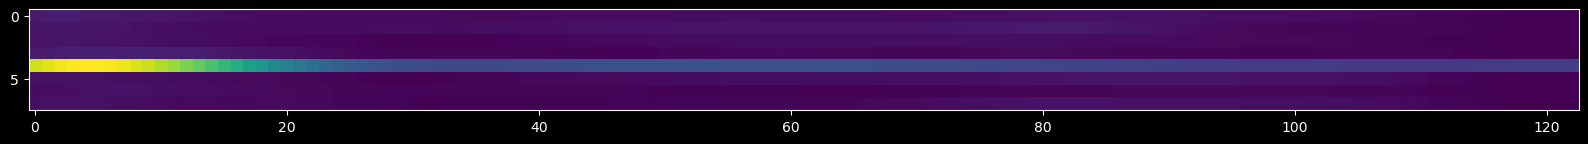

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(dop(x[2].numpy()))

In [6]:
x.max()

tensor(0.9954)

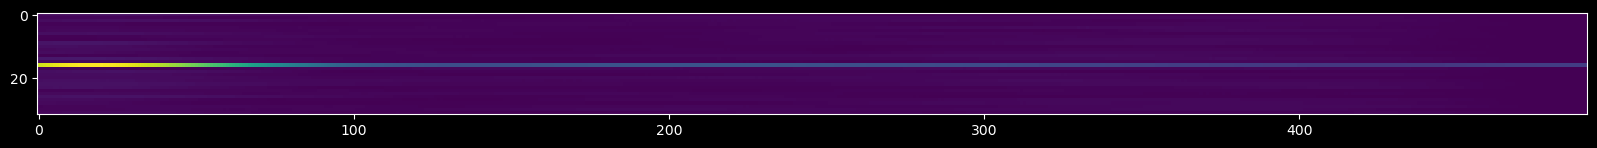

In [7]:
plt.figure(figsize=(20,10))
plt.imshow(dop(y[2].numpy()))

In [8]:
# getting model
model, optimizer, acc, loss_metric = setup_model(
    task=dp_cfg["task"],
    model_cfg=cfg.model_cfg,
    device=device,
)
# experiment name
data_pre_name = f"ds_{dp_cfg['ds_factor']}_original_dim_{dp_cfg['original_dims']}_pix_norm_{dp_cfg['pix_norm']}"
data_pre_name += f"_th_{extra_info}" if extra_info else ""
experiment_name = os.path.join(
    dp_cfg["task"],
    f"{model.model_name}_{loss_metric.name}",
    data_pre_name,
    get_time_in_string(),
)

# callbacks
callbacks = setup_callbacks(
    cfg.callbacks_cfg, base_dir=os.path.join(output_dir, experiment_name)
)

# #training
training_cfg = cfg.training_cfg
runner = Runner(
    model=model,
    loader_train=trainloader,
    loader_validation=valloader,
    device=device,
    optimizer=optimizer,
    loss_metric=loss_metric,
    acc_metric=acc,
    callbacks=callbacks,)

Creating directory at: /Users/netanelblumenfeld/Desktop/bgu/Msc/code/outputs/sr/Drln_2_loss_L1_0.25_MSSSIM_0.75/ds_4_original_dim_False_pix_norm_Normalization.Range_0_1/2024-01-23_16:47:45/tensorboard
Creating directory at: /Users/netanelblumenfeld/Desktop/bgu/Msc/code/outputs/sr/Drln_2_loss_L1_0.25_MSSSIM_0.75/ds_4_original_dim_False_pix_norm_Normalization.Range_0_1/2024-01-23_16:47:45/model


In [9]:
runner.run(epochs=training_cfg["epochs"])


KeyboardInterrupt: 